## Read and Process HTML files ##

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
import re
import unicodedata as ud
import seaborn as sns
import matplotlib.pyplot as plt

d = {ord('\N{COMBINING ACUTE ACCENT}'):None}

# Read html file
def read_file(file_path: str) -> list:
    with open(file_path, 'r') as file:
        html_content = file.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    text = soup.get_text()
    list_words = text.replace('\n', ' ').split(' ')
    return list_words

In [2]:
import os

files = os.listdir('./final_dataset_efeteio')
files = [f for f in files if f.endswith('.html')]

df = pd.DataFrame(columns=['script'])
for f in files:
    list_words = read_file(f'./final_dataset_efeteio/{f}')
    script = ' '.join(list_words)
    df.loc[f] = script    

df.sort_index(inplace=True)
df.head()

,script
1004.html,αριθμος αποφασης αριθμος αποφασης αριθμο...
1006.html,αριθμος αποφασης αριθμος αποφασης εφετει...
1008.html,αριθμος αποφασης αριθμος αποφασης εφετει...
1010.html,αριθμος αποφασης αριθμος αποφασης εφετει...
1012.html,αριθμος αποφασης αριθμος αποφασης εφετει...


In [3]:
df.shape

(3498, 1)

In [4]:
decisions = pd.read_csv('./preprocessed_efeteio/annotated_dataset.csv')    
decisions = decisions[decisions['Decision'].isin(df.index)]
decisions.set_index('Decision', inplace=True)
decisions.sort_index(inplace=True)
decisions.head()

,Label
Decision,
1004.html,1
1006.html,1
1008.html,1
1010.html,1
1012.html,0


In [5]:
decisions

,Label
Decision,
1004.html,1
1006.html,1
1008.html,1
1010.html,1
1012.html,0
...,...
9686.html,0
9688.html,1
969.html,1


In [6]:
decisions.value_counts()

Label
1        3101
0         397
Name: count, dtype: int64

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata

def preprocess_text(file_path):
    with open(file_path, 'r') as file:
        # Read the text from the file
        text = file.read()
        # Convert to lowercase
        text = text.lower()
        # Remove accents
        text = ''.join(char for char in unicodedata.normalize('NFKD', text) if not unicodedata.combining(char))
        # Remove punctuations
        text = re.sub(r'[^\w\s]', '', text)
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove English characters
        text = re.sub(r'[a-zA-Z]', '', text)
        # Remove all special chars
        text = text.replace('_', '')
        # Transforn to list of words
        text = text.replace('\n', ' ').split(' ')
    return text

# Example usage:
stop_words = preprocess_text('stopwords.txt')

## Creating a balanced dataset to work with ##

In [8]:
df['Label'] = decisions['Label'].values

df_0 = df[df['Label'] == 0]
df_1 = df[df['Label'] == 1]

df_0_sample = df_0.sample(380)
df_1_sample = df_1.sample(380)

df_resampled = pd.concat([df_0_sample, df_1_sample])
df_resampled['Label'].value_counts()

Label
0    380
1    380
Name: count, dtype: int64

In [9]:
df_resampled

,script,Label
9594.html,αριθμος αποφασης αριθμος αποφασης αριθμο...,0
2103.html,αριθμος αποφασης αριθμος αποφασης αριθμο...,0
7109.html,αριθμος αποφασης αριθμος αποφασης αριθμο...,0
1707.html,αριθμος αποφασης αριθμος αποφασης αριθμ...,0
5397.html,αριθμος αποφασης αριθμος αποφασης εφετει...,0
...,...,...
1034.html,αριθμος αποφασης αριθμος αποφασης αριθμο...,1
4762.html,αριθμος αποφασης αριθμος αποφασης αριθμο...,1
5179.html,αριθμος αποφασης αριθμος αποφασης αριθμο...,1
9202.html,αριθμος αποφασης αριθμος αποφασης εφετει...,1


## TF-IDF VECTORIZER ##
TF-IDF Vectorization:

It uses TfidfVectorizer from scikit-learn to convert the text data (df_resampled['script']) into a matrix of TF-IDF features.
The parameters used in TfidfVectorizer are:

norm='l2': This normalizes the vectors to have an L2 norm (unit norm).

stop_words=stop_words: This removes common stop words (as defined by the stop_words variable) from the text before vectorizing.

max_features=5000: Limits the vocabulary to the 5000 most frequent terms.

Transformation:

The fit_transform method is applied to the text data (df_resampled['script']), which learns the vocabulary and IDF (Inverse Document Frequency) values from the data, and then transforms the text data into a TF-IDF weighted term-document matrix.
This matrix is then converted into a dense array using .toarray().

Creating a DataFrame:

The TF-IDF matrix is then converted into a Pandas DataFrame (data_resampled), with the same index as the original DataFrame (df_resampled.index) and with columns named after the terms in the vocabulary (tfidf.get_feature_names_out()).
Appending the Label:

The 'Label' column from the original df_resampled DataFrame is added to the data_resampled DataFrame, aligning by index.





In [10]:
tfidf = TfidfVectorizer(norm='l2', stop_words=stop_words, max_features=5000)
tfidf_matrix = tfidf.fit_transform(df_resampled['script']).toarray()

data_resampled = pd.DataFrame(tfidf_matrix, index=df_resampled.index, columns=tfidf.get_feature_names_out())
data_resampled['Label'] = df_resampled['Label'].values

## Classifiers ##

# 1. Random Forest Classifier #

In [16]:
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

print(f'Accuracy: {rf.score(X_test, y_test)}')

# Calculate MCC
from sklearn.metrics import matthews_corrcoef, f1_score

mcc = f1_score(y_test, y_pred)
print(f'MCC: {mcc}')

Train shape: (509, 5000) | Test shape: (251, 5000)


NameError: name 'RandomForestClassifier' is not defined

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 2/5; 2/100] START bootstrap=True, max_depth=2, max_features=0.6, min_samples_leaf=2, min_samples_split=10, n_estimators=53
[CV 1/5; 1/100] START bootstrap=True, max_depth=30, max_features=0.5454545454545454, min_samples_leaf=2, min_samples_split=6, n_estimators=151
[CV 5/5; 1/100] START bootstrap=True, max_depth=30, max_features=0.5454545454545454, min_samples_leaf=2, min_samples_split=6, n_estimators=151
[CV 1/5; 2/100] START bootstrap=True, max_depth=2, max_features=0.6, min_samples_leaf=2, min_samples_split=10, n_estimators=53
[CV 3/5; 2/100] START bootstrap=True, max_depth=2, max_features=0.6, min_samples_leaf=2, min_samples_split=10, n_estimators=53
[CV 3/5; 1/100] START bootstrap=True, max_depth=30, max_features=0.5454545454545454, min_samples_leaf=2, min_samples_split=6, n_estimators=151
[CV 4/5; 1/100] START bootstrap=True, max_depth=30, max_features=0.5454545454545454, min_samples_leaf=2, min_samples_split=6, n

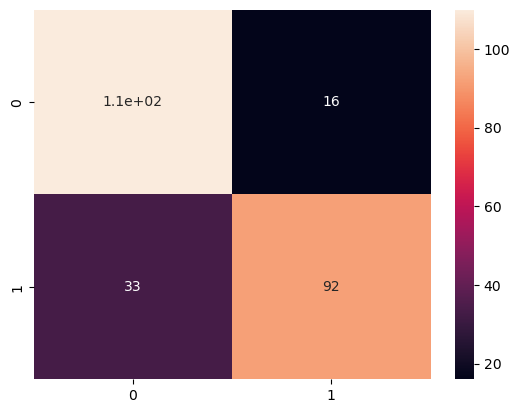

Accuracy: 0.8047808764940239
Accuracy: 0.8047808764940239
MCC: 0.615019653908409
F1: 0.7896995708154506


In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# # Assuming your data is preprocessed and resampled
# X = data_resampled.drop('Label', axis=1)
# y = data_resampled['Label']

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
# print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 50, 80, 100, 200, 300],           # Number of trees in the forest
    'max_depth': [None, 2, 4, 6, 8, 12, 20, 30],           # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required at a leaf node
    'bootstrap': [True, False],                # Whether bootstrap samples are used when building trees
    'max_features': ['auto', 'sqrt', 'log2']   # Number of features to consider when looking for the best split
}

param_dist = {
    'n_estimators': np.linspace(5, 200, 5, dtype=int),           # Number of trees in the forest
    'max_depth': np.linspace(2, 30, 5, dtype=int),           # Maximum depth of the tree
    'min_samples_split': np.linspace(2, 10, 3, dtype=int),           # Minimum number of samples required to split a node
    'min_samples_leaf': np.linspace(1, 4, 3, dtype=int),             # Minimum number of samples required at a leaf node
    'bootstrap': [True, False],                # Whether bootstrap samples are used when building trees
    'max_features': np.linspace(0.1, 1.0, 100)   # Number of features to consider when looking for the best split
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Set up GridSearchCV
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
#                            scoring='matthews_corrcoef',    # You can choose 'accuracy', 'f1', 'roc_auc', etc.
#                            cv=5,            # 5-fold cross-validation
#                            n_jobs=-1,       # Use all available cores
#                            verbose=20)


# Set up RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=5, verbose=20, n_jobs=-1)


# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best hyperparameters
print("Best hyperparameters found: ", grid_search.best_params_)

# Best estimator (RandomForest with best hyperparameters)
best_rf = grid_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

# Print accuracy of the best model
print(f'Accuracy: {best_rf.score(X_test, y_test)}')

# Calculate F1 score (MCC-like)
f1_score = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}')
print(f'MCC: {mcc}')
print(f'F1: {f1_score}')


In [12]:
# Perform cross validation with the best model
from sklearn.model_selection import cross_val_score

# Cross validation
cv_acc = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy').mean()
cv_mcc = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='matthews_corrcoef').mean()
cv_f1 = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='f1').mean()

print(f'Cross-validation accuracy: {cv_acc}')
print(f'Cross-validation MCC: {cv_mcc}')
print(f'Cross-validation F1: {cv_f1}')



NameError: name 'best_rf' is not defined

## 2. Support Vector Machines ##

Train shape: (509, 5000) | Test shape: (251, 5000)


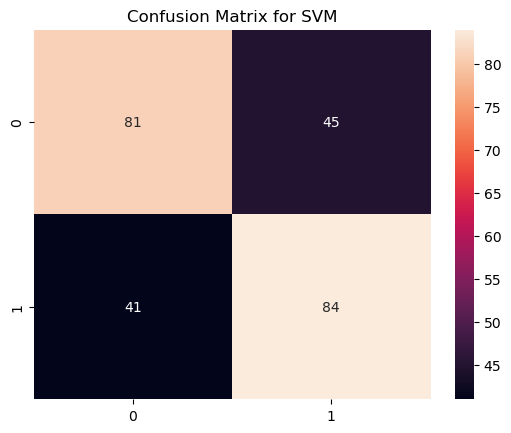

Accuracy: 0.6573705179282868
F1 Score: 0.6614173228346457


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Import the SVM classifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data into features and labels
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

# Step 3: Initialize and train the SVM classifier
svm = SVC(random_state=42)
svm.fit(X_train, y_train)

# Step 4: Evaluate the SVM classifier
y_pred = svm.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for SVM')
plt.show()

# Print Accuracy
accuracy = svm.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score (which was previously misnamed as MCC)
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC  # Import the SVM classifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data into features and labels
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

# Step 3: Set up the SVM classifier and the parameter grid for GridSearchCV
svm = SVC()

# Define a parameter grid to search for the best parameters
param_grid = {
    'C': [0.01,0.1, 0.5, 1, 10, 100],               # Regularization parameter
    'gamma': np.linspace(0, 1, 100),  # Kernel coefficient
    'kernel': ['linear', 'rbf']            # Kernel types
}
    

# Step 4: Set up GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Step 5: Fit the model to the training data with GridSearchCV
grid_search.fit(X_train, y_train)

# Step 6: Get the best estimator and print the best parameters
best_svm = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')

# Step 7: Use the best model to predict on the test data
y_pred = best_svm.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Best SVM Model')
plt.show()

# Print Accuracy
accuracy = best_svm.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


Train shape: (509, 5000) | Test shape: (251, 5000)


NameError: name 'np' is not defined

## 3. Linear Regression ## 

Train shape: (509, 5000) | Test shape: (251, 5000)


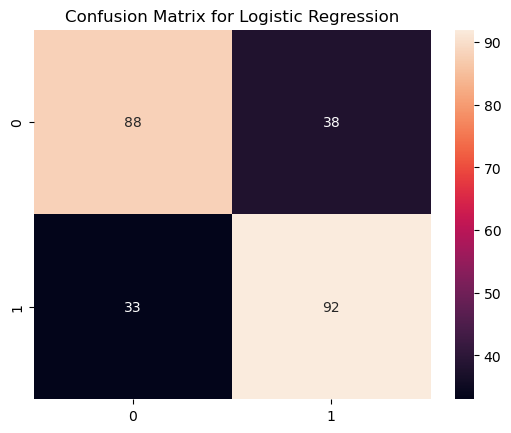

Accuracy: 0.7171314741035857
F1 Score: 0.7215686274509804


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Import Logistic Regression
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data into features and labels
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

# Step 3: Initialize and train the Logistic Regression classifier
lr = LogisticRegression(max_iter=2000)
lr.fit(X_train, y_train)

# Step 4: Evaluate the Logistic Regression classifier
y_pred = lr.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

# Print Accuracy
accuracy = lr.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


Train shape: (509, 5000) | Test shape: (251, 5000)
Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l2, solver=liblinear; total time=   0

/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=  25.3s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=  25.3s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time=   0.1s


/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l1, solver=saga; total time=  28.5s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.1s


/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l1, solver=saga; total time=  29.0s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   2.2s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   2.6s


/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=1000, penalty=l1, solver=saga; total time=  36.2s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.1s
[CV] END ...............C=1000, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=1000, penalty=l1, solver=saga; total time=  36.6s


/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   5.8s


/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=  23.9s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   8.1s


/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l1, solver=saga; total time=  27.4s


/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=1000, penalty=l1, solver=saga; total time=  35.0s


/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=  24.5s


/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l1, solver=saga; total time=  27.3s


/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ......................C=10, penalty=l1, solver=saga; total time=  23.9s


/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END ....................C=1000, penalty=l1, solver=saga; total time=  35.4s


/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV] END .....................C=100, penalty=l1, solver=saga; total time=  27.1s


/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
140 fits failed out of a total of 280.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/thodorismexis/anaco

[CV] END ....................C=1000, penalty=l1, solver=saga; total time=  34.0s
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'saga'}


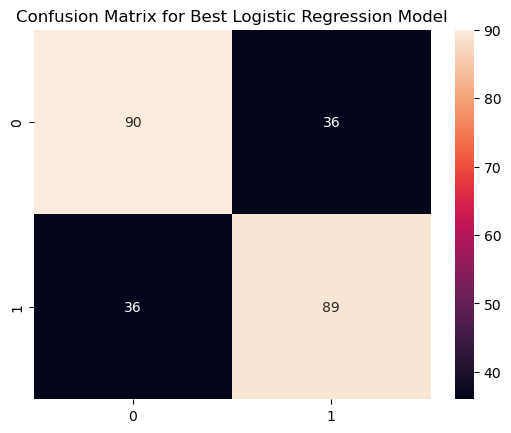

Accuracy: 0.7131474103585658
F1 Score: 0.712


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler



# Step 1: Split the data into features and labels
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Set up the Logistic Regression classifier and the parameter grid for GridSearchCV
lr = LogisticRegression(max_iter=2000)

# Define a parameter grid to search for the best parameters
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],        # Inverse of regularization strength
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization types
    'solver': ['saga','liblinear'],                     # Solver for 'elasticnet' regularization
}

# Step 4: Set up GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Step 5: Fit the model to the training data with GridSearchCV
grid_search.fit(X_train, y_train)

# Step 6: Get the best estimator and print the best parameters
best_lr = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')

# Step 7: Use the best model to predict on the test data
y_pred = best_lr.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Best Logistic Regression Model')
plt.show()

# Print Accuracy
accuracy = best_lr.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


In [15]:
import pandas as pd

df = pd.read_csv("hf://datasets/DominusTea/GreekLegalSum/hugginface_dataset.csv")


# 4. Decision Trees

Train shape: (509, 5000) | Test shape: (251, 5000)


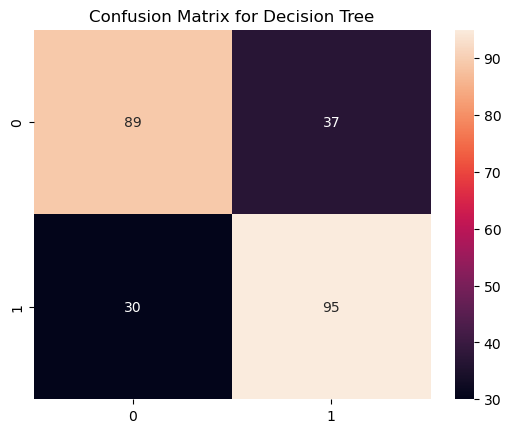

Accuracy: 0.7330677290836654
F1 Score: 0.7392996108949417


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree Classifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Split the data into features and labels
X = data_resampled.drop('Label', axis=1)
y = data_resampled['Label']

# Step 2: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

# Step 3: Initialize and train the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Step 4: Evaluate the Decision Tree classifier
y_pred = dt.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Decision Tree')
plt.show()

# Print Accuracy
accuracy = dt.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


In [26]:
df

,text,summary,case_category,case_tags,subset
0,ΑΡΙΘΜΟΣ 970/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,Αίτηση αναίρεσης καταδικαστικής αποφάσεως για ...,Ακυρότητα απόλυτη,"Αιτιολογίας επάρκεια, Ακυρότητα απόλυτη, Απάτη...",0.0
1,Αριθμός 1692/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,Καθορισμός συνολικής ποινής (άρθρο 551 ΚΠΔ) με...,Ποινή συνολική,"Ποινή συνολική, Νόμου εφαρμογή και ερμηνεία, Ε...",0.0
2,Αριθμός 92/2013 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ Π...,Καταδικαστική απόφαση για μη καταβολή χρεών πρ...,Ακυρότητα απόλυτη,"Ακυρότητα απόλυτη, Αοριστία λόγου αναιρέσεως, ...",0.0
3,Αριθμός 1502/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,Αναίρεση Εισαγγελέα Αρείου Πάγου κατά αθωωτική...,Αβάσιμοι λόγοι,"Αναιρέσεως απόρριψη, Εισαγγελέας Αρείου Πάγου,...",2.0
4,Αριθμός 1501/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,Κατ' εξακολούθηση απάτη κατ' επάγγελμα και κατ...,Αβάσιμοι λόγοι,"Ακυρότητα απόλυτη, Αναιρέσεως απόρριψη, Απάτη,...",1.0
...,...,...,...,...,...
8390,Αριθμός 542/2012 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,Δημόσιο. Ομόρρυθμη εταιρεία. Παραγραφή. Πενταε...,NaN,NaN,0.0
8391,ΑΡΙΘΜΟΣ 764/2012 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,Ορθή και αιτιολογημένη απόρριψη ισχυρισμού περ...,NaN,NaN,0.0
8392,ΑΡΙΘΜΟΣ 765/2012 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,Ορθή και αιτιολογημένη καταδίκη για ανθρωποκτο...,NaN,NaN,0.0
8393,Αριθμός 766/2012 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,Λαθρεμπορία τσιγάρων. Εισαγωγή κατοχή και πώλη...,NaN,NaN,0.0


In [27]:
df = df[['text']]

In [28]:
df

,text
0,ΑΡΙΘΜΟΣ 970/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...
1,Αριθμός 1692/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...
2,Αριθμός 92/2013 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ Π...
3,Αριθμός 1502/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...
4,Αριθμός 1501/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...
...,...
8390,Αριθμός 542/2012 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...
8391,ΑΡΙΘΜΟΣ 764/2012 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...
8392,ΑΡΙΘΜΟΣ 765/2012 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...
8393,Αριθμός 766/2012 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...
